In [1]:
from bertopic import BERTopic
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import matplotlib.pyplot as plt
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
import sys
sys.path.append("../..")
from utility import parse_config, seed_everything, custom_print
from preprocess_class import create_datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tingy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tingy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tingy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tingy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
from model_base_class import BaseModel

In [38]:
from umap import UMAP
from hdbscan import HDBSCAN

In [8]:
df = pd.read_csv('../../data/reviews.csv')
train, test = create_datasets(df)

In [3]:
def get_coherence_score(df, topic_model):
    """
    Evaluation metric for model
    """
    documents = pd.DataFrame({"Document": df.text,
                            "ID": range(len(df.text)),
                            "Topic": topic_model.topics_})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                for topic in range(len(set(topic_model.topics_))-1)]

    # Evaluate
    cm = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
                                    coherence='c_npmi', #'u_mass', 'c_v', 'c_uci', 'c_npmi'
                                    topn=5)
    return cm.get_coherence()

In [9]:
#can try with different stopwords
train.modify_stop_words_list(exclude_words=[])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#alternative, using PCA and Kmeans
dim_model = PCA(n_components=5)
topic_model = BERTopic(umap_model=dim_model)

cluster_model = KMeans(n_clusters=50)
topic_model = BERTopic(hdbscan_model=cluster_model)


In [9]:
#Start with vector
# Sentence transformer
#What to do with outliers
# umap_model = umap_model #dimension reduction model
# hdbscan_model = hdbscan_model #clustering model
ctfidf_params = {"bm25_weighting": True, "reduce_frequent_words": True}
vectorizer_params = {'min_df':10, 'max_df':1.0, "ngram_range": (1,2)}
embedding_model = "sentence-transformers/all-MiniLM-L12-v2" #should set up a few other models to try
ctfidf_model = ClassTfidfTransformer(bm25_weighting= ctfidf_params["bm25_weighting"], reduce_frequent_words= ctfidf_params["reduce_frequent_words"])
vectorizer_model = CountVectorizer(stop_words=train.stop_words_list, min_df = vectorizer_params['min_df'], max_df = vectorizer_params['min_df'],\
                                   ngram_range=vectorizer_params['ngram_range'])

umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False) #PCA or truncated SVD
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True) #k-mean, birch
# representation_model = MaximalMarginalRelevance(diversity=0.8) #0 least diverse and 1 most diverse
#min_topic_size = 70
topic_model = BERTopic(embedding_model=embedding_model, ctfidf_model=ctfidf_model,\
                        vectorizer_model=vectorizer_model, \
                        min_topic_size= 70,
                        # representation_model=representation_model, \
                        # umap_model = umap_model, \
                        # hdbscan_model = hdbscan_model, \
                        nr_topics= 'auto',
                        calculate_probabilities=False, verbose=True)
topics, probs = topic_model.fit_transform(train.text)
c_score = get_coherence_score(train, topic_model)
print(c_score)
# original_num_topic = len(topic_model.topic_labels_)
# model_results = {'Topics': [],
#                  'Coherence': []
#                 }
# c_score = get_coherence_score()
# model_results['Topics'].append(original_num_topic)
# model_results['Coherence'].append(c_score)
# for num_topic in range(original_num_topic-1,15 ,-1):
#     topic_model.reduce_topics(train['Text'], nr_topics=num_topic)
#     topics = topic_model.topics_
#     c_score = get_coherence_score()
#     model_results['Topics'].append(num_topic)
#     model_results['Coherence'].append(c_score)

Batches:   0%|          | 0/137 [00:00<?, ?it/s]

2023-03-28 13:23:55,299 - BERTopic - Transformed documents to Embeddings
2023-03-28 13:23:59,845 - BERTopic - Reduced dimensionality
2023-03-28 13:24:00,069 - BERTopic - Clustered reduced embeddings
2023-03-28 13:24:01,794 - BERTopic - Reduced number of topics from 14 to 10


0.11556440966277887


In [41]:
original_num_topic = len(topic_model.topic_labels_)
model_results = {'Topics': [],
                 'Coherence': []
                }
c_score = get_coherence_score(train, topic_model)
model_results['Topics'].append(original_num_topic)
model_results['Coherence'].append(c_score)
for num_topic in range(original_num_topic-1,15 ,-1):
    topic_model.reduce_topics(train.text, nr_topics=num_topic)
    topics = topic_model.topics_
    c_score = get_coherence_score(train, topic_model)
    model_results['Topics'].append(num_topic)
    model_results['Coherence'].append(c_score)

2023-03-28 02:04:59,456 - BERTopic - Reduced number of topics from 72 to 71
2023-03-28 02:05:15,073 - BERTopic - Reduced number of topics from 71 to 70
2023-03-28 02:05:30,759 - BERTopic - Reduced number of topics from 70 to 69
2023-03-28 02:05:46,623 - BERTopic - Reduced number of topics from 69 to 68
2023-03-28 02:06:01,927 - BERTopic - Reduced number of topics from 68 to 67
2023-03-28 02:06:17,240 - BERTopic - Reduced number of topics from 67 to 66
2023-03-28 02:06:32,686 - BERTopic - Reduced number of topics from 66 to 65
2023-03-28 02:06:48,224 - BERTopic - Reduced number of topics from 65 to 64
2023-03-28 02:07:03,790 - BERTopic - Reduced number of topics from 64 to 63
2023-03-28 02:07:18,956 - BERTopic - Reduced number of topics from 63 to 62
2023-03-28 02:07:33,993 - BERTopic - Reduced number of topics from 62 to 61
2023-03-28 02:07:48,895 - BERTopic - Reduced number of topics from 61 to 60
2023-03-28 02:08:03,849 - BERTopic - Reduced number of topics from 60 to 59
2023-03-28 0

In [37]:
class BERTopic_model(BaseModel):
    """
    BERTOpic model for topic modelling task
    """
    def __init__(self, embedding_model = None, clustering_model = None, vectorizer_model=None, 
                 ctfidf_model=None, dim_reduction_model=None, representation_model=None,
                 min_topic_size = 10):
        self.topic_model = None
        self.embedding_model = embedding_model
        self.clustering_model = clustering_model
        self.vectorizer_model = vectorizer_model
        self.ctfidf_model = ctfidf_model
        self.dim_reduction_model = dim_reduction_model
        self.representation_model =representation_model
        self.min_topic_size = min_topic_size
    
    def train(self, dataset):
        self.topic_model = BERTopic(embedding_model=self.embedding_model, ctfidf_model=self.ctfidf_model,\
                        vectorizer_model=self.vectorizer_model, \
                        min_topic_size= self.min_topic_size,
                        representation_model=self.representation_model, \
                        umap_model = self.dim_reduction_model, \
                        hdbscan_model = self.clustering_model, \
                        nr_topics= 'auto',
                        calculate_probabilities=False, verbose=True)
        self.topic_model.fit_transform(dataset.text)

    def evaluate(self,dataset):
        """
        Evaluate performance of model using coherence_score. As it is a unsupervised method, we need to manually check if the topics make sense as well
        """
        c_score = get_coherence_score(dataset, self.topic_model)
        return c_score
    
    def predict(self, dataset):
        return self.topic_model.transform(dataset.text)

    def get_coherence_score(dataset, topic_model):
        """
        Evaluation metric for model
        """
        documents = pd.DataFrame({"Document": dataset.text,
                                "ID": range(len(dataset.text)),
                                "Topic": topic_model.topics_})
        documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
        cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

        # Extract vectorizer and analyzer from BERTopic
        vectorizer = topic_model.vectorizer_model
        analyzer = vectorizer.build_analyzer()

        # Extract features for Topic Coherence evaluation
        tokens = [analyzer(doc) for doc in cleaned_docs]
        dictionary = corpora.Dictionary(tokens)
        corpus = [dictionary.doc2bow(token) for token in tokens]
        topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                    for topic in range(len(set(topic_model.topics_))-1)]

        # Evaluate
        cm = CoherenceModel(topics=topic_words, 
                                        texts=tokens, 
                                        corpus=corpus,
                                        dictionary=dictionary, 
                                        coherence='c_npmi', #'u_mass', 'c_v', 'c_uci', 'c_npmi'
                                        topn=5)
        return cm.get_coherence()

In [30]:
ctfidf_params = {"bm25_weighting": True, "reduce_frequent_words": True}
vectorizer_params = {'min_df':5, 'max_df':1.0, "ngram_range": (1,2)}
embedding_model = "sentence-transformers/all-MiniLM-L12-v2" #should set up a few other models to try
ctfidf_model = ClassTfidfTransformer(bm25_weighting= ctfidf_params["bm25_weighting"], reduce_frequent_words= ctfidf_params["reduce_frequent_words"])
vectorizer_model = CountVectorizer(stop_words=train.stop_words_list, min_df = vectorizer_params['min_df'], max_df = vectorizer_params['min_df'],\
                                   ngram_range=vectorizer_params['ngram_range'])

# umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False) #PCA or truncated SVD
# hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True) #k-mean, birch
representation_model = MaximalMarginalRelevance(diversity=0.5) #0 least diverse and 1 most diverse
min_topic_size = 50
model = BERTopic_model(embedding_model = embedding_model, clustering_model = None, vectorizer_model=vectorizer_model, 
                 ctfidf_model=ctfidf_model, dim_reduction_model=None, representation_model=representation_model,
                 min_topic_size = min_topic_size)
model.train(train)

Batches:   0%|          | 0/137 [00:00<?, ?it/s]

2023-03-28 17:07:28,169 - BERTopic - Transformed documents to Embeddings
2023-03-28 17:07:33,147 - BERTopic - Reduced dimensionality
2023-03-28 17:07:33,350 - BERTopic - Clustered reduced embeddings
2023-03-28 17:07:41,777 - BERTopic - Reduced number of topics from 20 to 20


In [36]:
get_coherence_score(train, model.topic_model)

-0.372271262664038

In [23]:
topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                 topic_prefix=False,
                                                 word_length=10,
                                                 separator=", ")
topic_model.set_topic_labels(topic_labels)
# topic_model.set_topic_labels({1: "Space Travel", 7: "Religion"}) #manual

In [33]:
model.topic_model.visualize_topics(custom_labels=True)
# topic_model.visualize_barchart(top_n_topics=16, custom_labels=True)

In [34]:
freq = model.topic_model.get_topic_info()
freq# Select the most frequent topic

,Topic,Count,Name
0,-1,1341,-1_maple syrup_paste_shakes_frosting
1,0,644,0_month old_95_gas_dried fruit
2,1,274,1_drink coffee_acidity_green mountain_grind
3,2,267,2_rose_steep_cup tea_hot cold
4,3,260,3_dogs_newman_food products_bank
5,4,193,4_carbonated_orange juice_140 calories_tang
6,5,169,5_grass_tasting product_carrots_taste smooth
7,6,134,6_salad dressing_sandwiches_spaghetti_olive oil
8,7,120,7_try ll_pink_seafood_overall recommend
9,8,108,8_kettle_carbohydrate_perfect snack_munching


In [2]:
#First attempt at bertopics
df = pd.read_csv('reviews.csv')
train, test = train_test_split(df, test_size = 0.2, random_state = 4263, stratify = df['Sentiment'])
train.reset_index(inplace=True)
train['Time'] = pd.to_datetime(df['Time'])
train['Text'] = train['Text'].apply(lambda x: sub("<[^>]+>", "", x).strip())

Pillars for bertopic
Embedding, dimension reduction, clustering, tokenizer, word weighting scheme\
For embedding:\
Transformer\
Gensim\
USE\
spacy\
For dimension reduction:\
UMAP\
PCA\
For clustering:\
HDBSCAN\
K-means (you can choose the number of clusters, can be highly noisy)\
For tokenizer/word weighting\
Count vectorizer (can adjust ngram/stopwords/min df etc)

In [30]:
#Start with vector
# Sentence transformer
#What to do with outliers
# umap_model = umap_model #dimension reduction model
# hdbscan_model = hdbscan_model #clustering model
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(embedding_model="sentence-transformers/all-MiniLM-L12-v2", ctfidf_model=ctfidf_model,\
                       vectorizer_model=vectorizer_model, calculate_probabilities=False, verbose=True)
topics, probs = topic_model.fit_transform(train['Text'])
original_num_topic = len(topic_model.topic_labels_)
model_results = {'Topics': [],
                 'Coherence': []
                }
c_score = get_coherence_score()
model_results['Topics'].append(original_num_topic)
model_results['Coherence'].append(c_score)
for num_topic in range(original_num_topic-1,15 ,-1):
    topic_model.reduce_topics(train['Text'], nr_topics=num_topic)
    topics = topic_model.topics_
    c_score = get_coherence_score()
    model_results['Topics'].append(num_topic)
    model_results['Coherence'].append(c_score)

2023-03-20 12:24:21,000 - BERTopic - Reduced number of topics from 68 to 66
2023-03-20 12:24:34,531 - BERTopic - Reduced number of topics from 66 to 65
2023-03-20 12:24:48,330 - BERTopic - Reduced number of topics from 65 to 64
2023-03-20 12:25:02,059 - BERTopic - Reduced number of topics from 64 to 63
2023-03-20 12:25:15,831 - BERTopic - Reduced number of topics from 63 to 62
2023-03-20 12:25:29,368 - BERTopic - Reduced number of topics from 62 to 61
2023-03-20 12:25:42,791 - BERTopic - Reduced number of topics from 61 to 60
2023-03-20 12:25:56,254 - BERTopic - Reduced number of topics from 60 to 59
2023-03-20 12:26:09,827 - BERTopic - Reduced number of topics from 59 to 58
2023-03-20 12:26:23,272 - BERTopic - Reduced number of topics from 58 to 57
2023-03-20 12:26:37,291 - BERTopic - Reduced number of topics from 57 to 56
2023-03-20 12:26:50,676 - BERTopic - Reduced number of topics from 56 to 55
2023-03-20 12:27:03,843 - BERTopic - Reduced number of topics from 55 to 54
2023-03-20 1

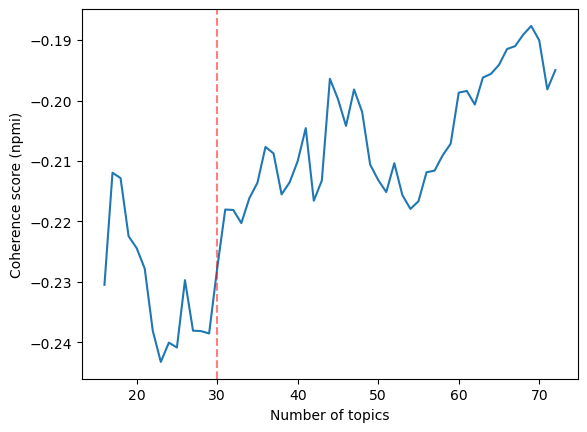

In [43]:
plt.plot(model_results['Topics'], model_results['Coherence'])
plt.axvline(30, color ='r', linestyle ='--', alpha = 0.5)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score (npmi)')
plt.show()

In [ ]:
#OR distilbert-base-nli-stsb-mean-tokens
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(df['Text'])

# Fine-tune topic representations after training BERTopic
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3)) #see if need stop words removal
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [32]:
freq = topic_model.get_topic_info()
freq# Select the most frequent topic

,Topic,Count,Name,CustomName
0,-1,1179,-1_oil_butter_milk_tried,"oil, butter, milk"
1,0,1531,0_price_buy_easy_amazon,"price, buy, easy"
2,1,304,1_sugar_natural_artificial_flavors,"sugar, natural, artificial"
3,2,294,2_coffee_cup_nice_flavor,"coffee, cup, nice"
4,3,280,3_honey_white_day_hot,"honey, white, day"
5,4,262,4_products_ingredients_treat_small,"products, ingredient, treat"
6,5,202,5_eating_sweet_healthy_carbs,"eating, sweet, healthy"
7,6,112,6_chocolate_ingredients_butter_texture,"chocolate, ingredient, butter"
8,7,109,7_bag_texture_calories_case,"bag, texture, calories"
9,8,82,8_chocolate_hot_milk_unfortunately,"chocolate, hot, milk"


In [ ]:
# The variable probabilities that is returned from transform() or fit_transform() can be used to understand how confident BERTopic is that certain topics can be found in a document.
#Doesnt seem to be working as expected atm, need to debug
# topics, probs = topic_model.transform(df['Text'])
# topic_model.visualize_distribution(probs, min_probability=0.2)

In [12]:
topic_model.visualize_hierarchy(top_n_topics=10)

In [13]:
topic_model.visualize_barchart(top_n_topics=16, custom_labels=True)

In [23]:
#possible things to do
#merge similar topics manually
topic_model.merge_topics(df['Text'], topics_to_merge=[1,4,5])
#iteratively merge
topic_model.reduce_topics(df['Text'], nr_topics=10)

In [48]:
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True, reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(embedding_model="sentence-transformers/all-MiniLM-L12-v2", ctfidf_model=ctfidf_model,\
                       vectorizer_model=vectorizer_model, nr_topics=30, calculate_probabilities=False, verbose=True)
topics, probs = topic_model.fit_transform(train['Text'])

Batches:   0%|          | 0/137 [00:00<?, ?it/s]

2023-03-20 13:08:46,916 - BERTopic - Transformed documents to Embeddings
2023-03-20 13:08:52,104 - BERTopic - Reduced dimensionality
2023-03-20 13:08:52,275 - BERTopic - Clustered reduced embeddings
2023-03-20 13:08:56,274 - BERTopic - Reduced number of topics from 72 to 30


In [29]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10) #see if need stop words removal
topic_model.update_topics(train['Text'], vectorizer_model=vectorizer_model)

In [45]:
topics_over_time = topic_model.topics_over_time(docs=train['Text'], 
                                                timestamps=train['Time'], 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

19it [00:00, 24.53it/s]


In [46]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=15)

In [33]:
#Change how labels are generated
topic_labels = topic_model.generate_topic_labels(nr_words = 3, topic_prefix=False, word_length=15, separator='-')
topic_model.set_topic_labels(topic_labels)

#Or to create for specific
topic_model.set_topic_labels({0:"Cold Drink", 1:"Coffee beans"})
topic_model.get_topic_info().head(10)

,Topic,Count,Name,CustomName
0,-1,1269,-1_great_product_good_taste,great-product-good
1,0,347,0_tea_green_iced_drink,Cold Drink
2,1,324,1_coffee_cup_starbucks_beans,Coffee beans
3,2,207,2_product_tastes_taste_great,product-tastes-taste
4,3,167,3_snacks_snack_tasty_fruit,snacks-snack-tasty
5,4,147,4_chips_potato_bag_bbq,chips-potato-bag
6,5,135,5_orange_juice_soda_drink,orange-juice-soda
7,6,134,6_price_grocery_store_amazon,price-grocery-store
8,7,109,7_dog_treats_dogs_treat,dog-treats-dogs
9,8,98,8_nuts_almond_roasted_nut,nuts-almond-roasted


In [36]:
#finding specific topic
topic_model.find_topics('animal', top_n=3)

([12, 7, 17], [0.7597972611987327, 0.7444208026393664, 0.6740989352739281])

In [42]:
topic_model.get_topic(17)

[('china', 0.12490522790589333),
 ('treats', 0.08203824691364132),
 ('dogs', 0.05424114952046814),
 ('dog', 0.0519195313209965),
 ('chicken', 0.04853867168122317),
 ('products', 0.035656979428674934),
 ('usa', 0.03498047359496498),
 ('country', 0.017893434052750193),
 ('sick', 0.017820012181890593),
 ('food', 0.01726687124620462)]

In [25]:
# Save model
topic_model.save("bertopic_model")	

In [28]:
# Load model
topic_model = BERTopic.load("bertopic_model")	